In [70]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from eofs.xarray import Eof
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping

In [71]:
pyproj.set_use_global_context(True)

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'

In [3]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Basal Melt Flux Generator

### E3SM Data Input

In [4]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

### EOF/PC Decomposition

In [5]:
%%time
model = EOF(flux_clean)
model.solve()
xeofs_eofs = model.eofs()
xeofs_pcs = model.pcs()

CPU times: user 2min 24s, sys: 50.5 s, total: 3min 15s
Wall time: 47.7 s


In [6]:
xeofs_n_modes = model.n_modes

## Phase Randomization

In [145]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 15
t_length = xeofs_pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,xeofs_pcs.shape[0],xeofs_pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(xeofs_n_modes):
        fl = xeofs_pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization i, mode: {}'.format(m))

calculated ifft for realization i, mode: 0
calculated ifft for realization i, mode: 1
calculated ifft for realization i, mode: 2
calculated ifft for realization i, mode: 3
calculated ifft for realization i, mode: 4
calculated ifft for realization i, mode: 5
calculated ifft for realization i, mode: 6
calculated ifft for realization i, mode: 7
calculated ifft for realization i, mode: 8
calculated ifft for realization i, mode: 9
calculated ifft for realization i, mode: 10
calculated ifft for realization i, mode: 11
calculated ifft for realization i, mode: 12
calculated ifft for realization i, mode: 13
calculated ifft for realization i, mode: 14
calculated ifft for realization i, mode: 15
calculated ifft for realization i, mode: 16
calculated ifft for realization i, mode: 17
calculated ifft for realization i, mode: 18
calculated ifft for realization i, mode: 19
calculated ifft for realization i, mode: 20
calculated ifft for realization i, mode: 21
calculated ifft for realization i, mode: 2

calculated ifft for realization i, mode: 577
calculated ifft for realization i, mode: 578
calculated ifft for realization i, mode: 579
calculated ifft for realization i, mode: 580
calculated ifft for realization i, mode: 581
calculated ifft for realization i, mode: 582
calculated ifft for realization i, mode: 583
calculated ifft for realization i, mode: 584
calculated ifft for realization i, mode: 585
calculated ifft for realization i, mode: 586
calculated ifft for realization i, mode: 587
calculated ifft for realization i, mode: 588
calculated ifft for realization i, mode: 589
calculated ifft for realization i, mode: 590
calculated ifft for realization i, mode: 591
calculated ifft for realization i, mode: 592
calculated ifft for realization i, mode: 593
calculated ifft for realization i, mode: 594
calculated ifft for realization i, mode: 595
calculated ifft for realization i, mode: 596
calculated ifft for realization i, mode: 597
calculated ifft for realization i, mode: 598
calculated

calculated ifft for realization i, mode: 1136
calculated ifft for realization i, mode: 1137
calculated ifft for realization i, mode: 1138
calculated ifft for realization i, mode: 1139
calculated ifft for realization i, mode: 1140
calculated ifft for realization i, mode: 1141
calculated ifft for realization i, mode: 1142
calculated ifft for realization i, mode: 1143
calculated ifft for realization i, mode: 1144
calculated ifft for realization i, mode: 1145
calculated ifft for realization i, mode: 1146
calculated ifft for realization i, mode: 1147
calculated ifft for realization i, mode: 1148
calculated ifft for realization i, mode: 1149
calculated ifft for realization i, mode: 1150
calculated ifft for realization i, mode: 1151
calculated ifft for realization i, mode: 1152
calculated ifft for realization i, mode: 1153
calculated ifft for realization i, mode: 1154
calculated ifft for realization i, mode: 1155
calculated ifft for realization i, mode: 1156
calculated ifft for realization i,

calculated ifft for realization i, mode: 236
calculated ifft for realization i, mode: 237
calculated ifft for realization i, mode: 238
calculated ifft for realization i, mode: 239
calculated ifft for realization i, mode: 240
calculated ifft for realization i, mode: 241
calculated ifft for realization i, mode: 242
calculated ifft for realization i, mode: 243
calculated ifft for realization i, mode: 244
calculated ifft for realization i, mode: 245
calculated ifft for realization i, mode: 246
calculated ifft for realization i, mode: 247
calculated ifft for realization i, mode: 248
calculated ifft for realization i, mode: 249
calculated ifft for realization i, mode: 250
calculated ifft for realization i, mode: 251
calculated ifft for realization i, mode: 252
calculated ifft for realization i, mode: 253
calculated ifft for realization i, mode: 254
calculated ifft for realization i, mode: 255
calculated ifft for realization i, mode: 256
calculated ifft for realization i, mode: 257
calculated

calculated ifft for realization i, mode: 837
calculated ifft for realization i, mode: 838
calculated ifft for realization i, mode: 839
calculated ifft for realization i, mode: 840
calculated ifft for realization i, mode: 841
calculated ifft for realization i, mode: 842
calculated ifft for realization i, mode: 843
calculated ifft for realization i, mode: 844
calculated ifft for realization i, mode: 845
calculated ifft for realization i, mode: 846
calculated ifft for realization i, mode: 847
calculated ifft for realization i, mode: 848
calculated ifft for realization i, mode: 849
calculated ifft for realization i, mode: 850
calculated ifft for realization i, mode: 851
calculated ifft for realization i, mode: 852
calculated ifft for realization i, mode: 853
calculated ifft for realization i, mode: 854
calculated ifft for realization i, mode: 855
calculated ifft for realization i, mode: 856
calculated ifft for realization i, mode: 857
calculated ifft for realization i, mode: 858
calculated

calculated ifft for realization i, mode: 1376
calculated ifft for realization i, mode: 1377
calculated ifft for realization i, mode: 1378
calculated ifft for realization i, mode: 1379
calculated ifft for realization i, mode: 1380
calculated ifft for realization i, mode: 1381
calculated ifft for realization i, mode: 1382
calculated ifft for realization i, mode: 1383
calculated ifft for realization i, mode: 1384
calculated ifft for realization i, mode: 1385
calculated ifft for realization i, mode: 1386
calculated ifft for realization i, mode: 1387
calculated ifft for realization i, mode: 1388
calculated ifft for realization i, mode: 1389
calculated ifft for realization i, mode: 1390
calculated ifft for realization i, mode: 1391
calculated ifft for realization i, mode: 1392
calculated ifft for realization i, mode: 1393
calculated ifft for realization i, mode: 1394
calculated ifft for realization i, mode: 1395
calculated ifft for realization i, mode: 1396
calculated ifft for realization i,

calculated ifft for realization i, mode: 344
calculated ifft for realization i, mode: 345
calculated ifft for realization i, mode: 346
calculated ifft for realization i, mode: 347
calculated ifft for realization i, mode: 348
calculated ifft for realization i, mode: 349
calculated ifft for realization i, mode: 350
calculated ifft for realization i, mode: 351
calculated ifft for realization i, mode: 352
calculated ifft for realization i, mode: 353
calculated ifft for realization i, mode: 354
calculated ifft for realization i, mode: 355
calculated ifft for realization i, mode: 356
calculated ifft for realization i, mode: 357
calculated ifft for realization i, mode: 358
calculated ifft for realization i, mode: 359
calculated ifft for realization i, mode: 360
calculated ifft for realization i, mode: 361
calculated ifft for realization i, mode: 362
calculated ifft for realization i, mode: 363
calculated ifft for realization i, mode: 364
calculated ifft for realization i, mode: 365
calculated

calculated ifft for realization i, mode: 895
calculated ifft for realization i, mode: 896
calculated ifft for realization i, mode: 897
calculated ifft for realization i, mode: 898
calculated ifft for realization i, mode: 899
calculated ifft for realization i, mode: 900
calculated ifft for realization i, mode: 901
calculated ifft for realization i, mode: 902
calculated ifft for realization i, mode: 903
calculated ifft for realization i, mode: 904
calculated ifft for realization i, mode: 905
calculated ifft for realization i, mode: 906
calculated ifft for realization i, mode: 907
calculated ifft for realization i, mode: 908
calculated ifft for realization i, mode: 909
calculated ifft for realization i, mode: 910
calculated ifft for realization i, mode: 911
calculated ifft for realization i, mode: 912
calculated ifft for realization i, mode: 913
calculated ifft for realization i, mode: 914
calculated ifft for realization i, mode: 915
calculated ifft for realization i, mode: 916
calculated

calculated ifft for realization i, mode: 1473
calculated ifft for realization i, mode: 1474
calculated ifft for realization i, mode: 1475
calculated ifft for realization i, mode: 1476
calculated ifft for realization i, mode: 1477
calculated ifft for realization i, mode: 1478
calculated ifft for realization i, mode: 1479
calculated ifft for realization i, mode: 1480
calculated ifft for realization i, mode: 1481
calculated ifft for realization i, mode: 1482
calculated ifft for realization i, mode: 1483
calculated ifft for realization i, mode: 1484
calculated ifft for realization i, mode: 1485
calculated ifft for realization i, mode: 1486
calculated ifft for realization i, mode: 1487
calculated ifft for realization i, mode: 1488
calculated ifft for realization i, mode: 1489
calculated ifft for realization i, mode: 1490
calculated ifft for realization i, mode: 1491
calculated ifft for realization i, mode: 1492
calculated ifft for realization i, mode: 1493
calculated ifft for realization i,

calculated ifft for realization i, mode: 529
calculated ifft for realization i, mode: 530
calculated ifft for realization i, mode: 531
calculated ifft for realization i, mode: 532
calculated ifft for realization i, mode: 533
calculated ifft for realization i, mode: 534
calculated ifft for realization i, mode: 535
calculated ifft for realization i, mode: 536
calculated ifft for realization i, mode: 537
calculated ifft for realization i, mode: 538
calculated ifft for realization i, mode: 539
calculated ifft for realization i, mode: 540
calculated ifft for realization i, mode: 541
calculated ifft for realization i, mode: 542
calculated ifft for realization i, mode: 543
calculated ifft for realization i, mode: 544
calculated ifft for realization i, mode: 545
calculated ifft for realization i, mode: 546
calculated ifft for realization i, mode: 547
calculated ifft for realization i, mode: 548
calculated ifft for realization i, mode: 549
calculated ifft for realization i, mode: 550
calculated

calculated ifft for realization i, mode: 1081
calculated ifft for realization i, mode: 1082
calculated ifft for realization i, mode: 1083
calculated ifft for realization i, mode: 1084
calculated ifft for realization i, mode: 1085
calculated ifft for realization i, mode: 1086
calculated ifft for realization i, mode: 1087
calculated ifft for realization i, mode: 1088
calculated ifft for realization i, mode: 1089
calculated ifft for realization i, mode: 1090
calculated ifft for realization i, mode: 1091
calculated ifft for realization i, mode: 1092
calculated ifft for realization i, mode: 1093
calculated ifft for realization i, mode: 1094
calculated ifft for realization i, mode: 1095
calculated ifft for realization i, mode: 1096
calculated ifft for realization i, mode: 1097
calculated ifft for realization i, mode: 1098
calculated ifft for realization i, mode: 1099
calculated ifft for realization i, mode: 1100
calculated ifft for realization i, mode: 1101
calculated ifft for realization i,

calculated ifft for realization i, mode: 114
calculated ifft for realization i, mode: 115
calculated ifft for realization i, mode: 116
calculated ifft for realization i, mode: 117
calculated ifft for realization i, mode: 118
calculated ifft for realization i, mode: 119
calculated ifft for realization i, mode: 120
calculated ifft for realization i, mode: 121
calculated ifft for realization i, mode: 122
calculated ifft for realization i, mode: 123
calculated ifft for realization i, mode: 124
calculated ifft for realization i, mode: 125
calculated ifft for realization i, mode: 126
calculated ifft for realization i, mode: 127
calculated ifft for realization i, mode: 128
calculated ifft for realization i, mode: 129
calculated ifft for realization i, mode: 130
calculated ifft for realization i, mode: 131
calculated ifft for realization i, mode: 132
calculated ifft for realization i, mode: 133
calculated ifft for realization i, mode: 134
calculated ifft for realization i, mode: 135
calculated

calculated ifft for realization i, mode: 617
calculated ifft for realization i, mode: 618
calculated ifft for realization i, mode: 619
calculated ifft for realization i, mode: 620
calculated ifft for realization i, mode: 621
calculated ifft for realization i, mode: 622
calculated ifft for realization i, mode: 623
calculated ifft for realization i, mode: 624
calculated ifft for realization i, mode: 625
calculated ifft for realization i, mode: 626
calculated ifft for realization i, mode: 627
calculated ifft for realization i, mode: 628
calculated ifft for realization i, mode: 629
calculated ifft for realization i, mode: 630
calculated ifft for realization i, mode: 631
calculated ifft for realization i, mode: 632
calculated ifft for realization i, mode: 633
calculated ifft for realization i, mode: 634
calculated ifft for realization i, mode: 635
calculated ifft for realization i, mode: 636
calculated ifft for realization i, mode: 637
calculated ifft for realization i, mode: 638
calculated

calculated ifft for realization i, mode: 1116
calculated ifft for realization i, mode: 1117
calculated ifft for realization i, mode: 1118
calculated ifft for realization i, mode: 1119
calculated ifft for realization i, mode: 1120
calculated ifft for realization i, mode: 1121
calculated ifft for realization i, mode: 1122
calculated ifft for realization i, mode: 1123
calculated ifft for realization i, mode: 1124
calculated ifft for realization i, mode: 1125
calculated ifft for realization i, mode: 1126
calculated ifft for realization i, mode: 1127
calculated ifft for realization i, mode: 1128
calculated ifft for realization i, mode: 1129
calculated ifft for realization i, mode: 1130
calculated ifft for realization i, mode: 1131
calculated ifft for realization i, mode: 1132
calculated ifft for realization i, mode: 1133
calculated ifft for realization i, mode: 1134
calculated ifft for realization i, mode: 1135
calculated ifft for realization i, mode: 1136
calculated ifft for realization i,

calculated ifft for realization i, mode: 120
calculated ifft for realization i, mode: 121
calculated ifft for realization i, mode: 122
calculated ifft for realization i, mode: 123
calculated ifft for realization i, mode: 124
calculated ifft for realization i, mode: 125
calculated ifft for realization i, mode: 126
calculated ifft for realization i, mode: 127
calculated ifft for realization i, mode: 128
calculated ifft for realization i, mode: 129
calculated ifft for realization i, mode: 130
calculated ifft for realization i, mode: 131
calculated ifft for realization i, mode: 132
calculated ifft for realization i, mode: 133
calculated ifft for realization i, mode: 134
calculated ifft for realization i, mode: 135
calculated ifft for realization i, mode: 136
calculated ifft for realization i, mode: 137
calculated ifft for realization i, mode: 138
calculated ifft for realization i, mode: 139
calculated ifft for realization i, mode: 140
calculated ifft for realization i, mode: 141
calculated

calculated ifft for realization i, mode: 679
calculated ifft for realization i, mode: 680
calculated ifft for realization i, mode: 681
calculated ifft for realization i, mode: 682
calculated ifft for realization i, mode: 683
calculated ifft for realization i, mode: 684
calculated ifft for realization i, mode: 685
calculated ifft for realization i, mode: 686
calculated ifft for realization i, mode: 687
calculated ifft for realization i, mode: 688
calculated ifft for realization i, mode: 689
calculated ifft for realization i, mode: 690
calculated ifft for realization i, mode: 691
calculated ifft for realization i, mode: 692
calculated ifft for realization i, mode: 693
calculated ifft for realization i, mode: 694
calculated ifft for realization i, mode: 695
calculated ifft for realization i, mode: 696
calculated ifft for realization i, mode: 697
calculated ifft for realization i, mode: 698
calculated ifft for realization i, mode: 699
calculated ifft for realization i, mode: 700
calculated

calculated ifft for realization i, mode: 1216
calculated ifft for realization i, mode: 1217
calculated ifft for realization i, mode: 1218
calculated ifft for realization i, mode: 1219
calculated ifft for realization i, mode: 1220
calculated ifft for realization i, mode: 1221
calculated ifft for realization i, mode: 1222
calculated ifft for realization i, mode: 1223
calculated ifft for realization i, mode: 1224
calculated ifft for realization i, mode: 1225
calculated ifft for realization i, mode: 1226
calculated ifft for realization i, mode: 1227
calculated ifft for realization i, mode: 1228
calculated ifft for realization i, mode: 1229
calculated ifft for realization i, mode: 1230
calculated ifft for realization i, mode: 1231
calculated ifft for realization i, mode: 1232
calculated ifft for realization i, mode: 1233
calculated ifft for realization i, mode: 1234
calculated ifft for realization i, mode: 1235
calculated ifft for realization i, mode: 1236
calculated ifft for realization i,

calculated ifft for realization i, mode: 200
calculated ifft for realization i, mode: 201
calculated ifft for realization i, mode: 202
calculated ifft for realization i, mode: 203
calculated ifft for realization i, mode: 204
calculated ifft for realization i, mode: 205
calculated ifft for realization i, mode: 206
calculated ifft for realization i, mode: 207
calculated ifft for realization i, mode: 208
calculated ifft for realization i, mode: 209
calculated ifft for realization i, mode: 210
calculated ifft for realization i, mode: 211
calculated ifft for realization i, mode: 212
calculated ifft for realization i, mode: 213
calculated ifft for realization i, mode: 214
calculated ifft for realization i, mode: 215
calculated ifft for realization i, mode: 216
calculated ifft for realization i, mode: 217
calculated ifft for realization i, mode: 218
calculated ifft for realization i, mode: 219
calculated ifft for realization i, mode: 220
calculated ifft for realization i, mode: 221
calculated

calculated ifft for realization i, mode: 656
calculated ifft for realization i, mode: 657
calculated ifft for realization i, mode: 658
calculated ifft for realization i, mode: 659
calculated ifft for realization i, mode: 660
calculated ifft for realization i, mode: 661
calculated ifft for realization i, mode: 662
calculated ifft for realization i, mode: 663
calculated ifft for realization i, mode: 664
calculated ifft for realization i, mode: 665
calculated ifft for realization i, mode: 666
calculated ifft for realization i, mode: 667
calculated ifft for realization i, mode: 668
calculated ifft for realization i, mode: 669
calculated ifft for realization i, mode: 670
calculated ifft for realization i, mode: 671
calculated ifft for realization i, mode: 672
calculated ifft for realization i, mode: 673
calculated ifft for realization i, mode: 674
calculated ifft for realization i, mode: 675
calculated ifft for realization i, mode: 676
calculated ifft for realization i, mode: 677
calculated

calculated ifft for realization i, mode: 1185
calculated ifft for realization i, mode: 1186
calculated ifft for realization i, mode: 1187
calculated ifft for realization i, mode: 1188
calculated ifft for realization i, mode: 1189
calculated ifft for realization i, mode: 1190
calculated ifft for realization i, mode: 1191
calculated ifft for realization i, mode: 1192
calculated ifft for realization i, mode: 1193
calculated ifft for realization i, mode: 1194
calculated ifft for realization i, mode: 1195
calculated ifft for realization i, mode: 1196
calculated ifft for realization i, mode: 1197
calculated ifft for realization i, mode: 1198
calculated ifft for realization i, mode: 1199
calculated ifft for realization i, mode: 1200
calculated ifft for realization i, mode: 1201
calculated ifft for realization i, mode: 1202
calculated ifft for realization i, mode: 1203
calculated ifft for realization i, mode: 1204
calculated ifft for realization i, mode: 1205
calculated ifft for realization i,

calculated ifft for realization i, mode: 206
calculated ifft for realization i, mode: 207
calculated ifft for realization i, mode: 208
calculated ifft for realization i, mode: 209
calculated ifft for realization i, mode: 210
calculated ifft for realization i, mode: 211
calculated ifft for realization i, mode: 212
calculated ifft for realization i, mode: 213
calculated ifft for realization i, mode: 214
calculated ifft for realization i, mode: 215
calculated ifft for realization i, mode: 216
calculated ifft for realization i, mode: 217
calculated ifft for realization i, mode: 218
calculated ifft for realization i, mode: 219
calculated ifft for realization i, mode: 220
calculated ifft for realization i, mode: 221
calculated ifft for realization i, mode: 222
calculated ifft for realization i, mode: 223
calculated ifft for realization i, mode: 224
calculated ifft for realization i, mode: 225
calculated ifft for realization i, mode: 226
calculated ifft for realization i, mode: 227
calculated

calculated ifft for realization i, mode: 765
calculated ifft for realization i, mode: 766
calculated ifft for realization i, mode: 767
calculated ifft for realization i, mode: 768
calculated ifft for realization i, mode: 769
calculated ifft for realization i, mode: 770
calculated ifft for realization i, mode: 771
calculated ifft for realization i, mode: 772
calculated ifft for realization i, mode: 773
calculated ifft for realization i, mode: 774
calculated ifft for realization i, mode: 775
calculated ifft for realization i, mode: 776
calculated ifft for realization i, mode: 777
calculated ifft for realization i, mode: 778
calculated ifft for realization i, mode: 779
calculated ifft for realization i, mode: 780
calculated ifft for realization i, mode: 781
calculated ifft for realization i, mode: 782
calculated ifft for realization i, mode: 783
calculated ifft for realization i, mode: 784
calculated ifft for realization i, mode: 785
calculated ifft for realization i, mode: 786
calculated

calculated ifft for realization i, mode: 1326
calculated ifft for realization i, mode: 1327
calculated ifft for realization i, mode: 1328
calculated ifft for realization i, mode: 1329
calculated ifft for realization i, mode: 1330
calculated ifft for realization i, mode: 1331
calculated ifft for realization i, mode: 1332
calculated ifft for realization i, mode: 1333
calculated ifft for realization i, mode: 1334
calculated ifft for realization i, mode: 1335
calculated ifft for realization i, mode: 1336
calculated ifft for realization i, mode: 1337
calculated ifft for realization i, mode: 1338
calculated ifft for realization i, mode: 1339
calculated ifft for realization i, mode: 1340
calculated ifft for realization i, mode: 1341
calculated ifft for realization i, mode: 1342
calculated ifft for realization i, mode: 1343
calculated ifft for realization i, mode: 1344
calculated ifft for realization i, mode: 1345
calculated ifft for realization i, mode: 1346
calculated ifft for realization i,

calculated ifft for realization i, mode: 361
calculated ifft for realization i, mode: 362
calculated ifft for realization i, mode: 363
calculated ifft for realization i, mode: 364
calculated ifft for realization i, mode: 365
calculated ifft for realization i, mode: 366
calculated ifft for realization i, mode: 367
calculated ifft for realization i, mode: 368
calculated ifft for realization i, mode: 369
calculated ifft for realization i, mode: 370
calculated ifft for realization i, mode: 371
calculated ifft for realization i, mode: 372
calculated ifft for realization i, mode: 373
calculated ifft for realization i, mode: 374
calculated ifft for realization i, mode: 375
calculated ifft for realization i, mode: 376
calculated ifft for realization i, mode: 377
calculated ifft for realization i, mode: 378
calculated ifft for realization i, mode: 379
calculated ifft for realization i, mode: 380
calculated ifft for realization i, mode: 381
calculated ifft for realization i, mode: 382
calculated

calculated ifft for realization i, mode: 918
calculated ifft for realization i, mode: 919
calculated ifft for realization i, mode: 920
calculated ifft for realization i, mode: 921
calculated ifft for realization i, mode: 922
calculated ifft for realization i, mode: 923
calculated ifft for realization i, mode: 924
calculated ifft for realization i, mode: 925
calculated ifft for realization i, mode: 926
calculated ifft for realization i, mode: 927
calculated ifft for realization i, mode: 928
calculated ifft for realization i, mode: 929
calculated ifft for realization i, mode: 930
calculated ifft for realization i, mode: 931
calculated ifft for realization i, mode: 932
calculated ifft for realization i, mode: 933
calculated ifft for realization i, mode: 934
calculated ifft for realization i, mode: 935
calculated ifft for realization i, mode: 936
calculated ifft for realization i, mode: 937
calculated ifft for realization i, mode: 938
calculated ifft for realization i, mode: 939
calculated

calculated ifft for realization i, mode: 2
calculated ifft for realization i, mode: 3
calculated ifft for realization i, mode: 4
calculated ifft for realization i, mode: 5
calculated ifft for realization i, mode: 6
calculated ifft for realization i, mode: 7
calculated ifft for realization i, mode: 8
calculated ifft for realization i, mode: 9
calculated ifft for realization i, mode: 10
calculated ifft for realization i, mode: 11
calculated ifft for realization i, mode: 12
calculated ifft for realization i, mode: 13
calculated ifft for realization i, mode: 14
calculated ifft for realization i, mode: 15
calculated ifft for realization i, mode: 16
calculated ifft for realization i, mode: 17
calculated ifft for realization i, mode: 18
calculated ifft for realization i, mode: 19
calculated ifft for realization i, mode: 20
calculated ifft for realization i, mode: 21
calculated ifft for realization i, mode: 22
calculated ifft for realization i, mode: 23
calculated ifft for realization i, mode:

calculated ifft for realization i, mode: 555
calculated ifft for realization i, mode: 556
calculated ifft for realization i, mode: 557
calculated ifft for realization i, mode: 558
calculated ifft for realization i, mode: 559
calculated ifft for realization i, mode: 560
calculated ifft for realization i, mode: 561
calculated ifft for realization i, mode: 562
calculated ifft for realization i, mode: 563
calculated ifft for realization i, mode: 564
calculated ifft for realization i, mode: 565
calculated ifft for realization i, mode: 566
calculated ifft for realization i, mode: 567
calculated ifft for realization i, mode: 568
calculated ifft for realization i, mode: 569
calculated ifft for realization i, mode: 570
calculated ifft for realization i, mode: 571
calculated ifft for realization i, mode: 572
calculated ifft for realization i, mode: 573
calculated ifft for realization i, mode: 574
calculated ifft for realization i, mode: 575
calculated ifft for realization i, mode: 576
calculated

calculated ifft for realization i, mode: 839
calculated ifft for realization i, mode: 840
calculated ifft for realization i, mode: 841
calculated ifft for realization i, mode: 842
calculated ifft for realization i, mode: 843
calculated ifft for realization i, mode: 844
calculated ifft for realization i, mode: 845
calculated ifft for realization i, mode: 846
calculated ifft for realization i, mode: 847
calculated ifft for realization i, mode: 848
calculated ifft for realization i, mode: 849
calculated ifft for realization i, mode: 850
calculated ifft for realization i, mode: 851
calculated ifft for realization i, mode: 852
calculated ifft for realization i, mode: 853
calculated ifft for realization i, mode: 854
calculated ifft for realization i, mode: 855
calculated ifft for realization i, mode: 856
calculated ifft for realization i, mode: 857
calculated ifft for realization i, mode: 858
calculated ifft for realization i, mode: 859
calculated ifft for realization i, mode: 860
calculated

calculated ifft for realization i, mode: 1111
calculated ifft for realization i, mode: 1112
calculated ifft for realization i, mode: 1113
calculated ifft for realization i, mode: 1114
calculated ifft for realization i, mode: 1115
calculated ifft for realization i, mode: 1116
calculated ifft for realization i, mode: 1117
calculated ifft for realization i, mode: 1118
calculated ifft for realization i, mode: 1119
calculated ifft for realization i, mode: 1120
calculated ifft for realization i, mode: 1121
calculated ifft for realization i, mode: 1122
calculated ifft for realization i, mode: 1123
calculated ifft for realization i, mode: 1124
calculated ifft for realization i, mode: 1125
calculated ifft for realization i, mode: 1126
calculated ifft for realization i, mode: 1127
calculated ifft for realization i, mode: 1128
calculated ifft for realization i, mode: 1129
calculated ifft for realization i, mode: 1130
calculated ifft for realization i, mode: 1131
calculated ifft for realization i,

calculated ifft for realization i, mode: 126
calculated ifft for realization i, mode: 127
calculated ifft for realization i, mode: 128
calculated ifft for realization i, mode: 129
calculated ifft for realization i, mode: 130
calculated ifft for realization i, mode: 131
calculated ifft for realization i, mode: 132
calculated ifft for realization i, mode: 133
calculated ifft for realization i, mode: 134
calculated ifft for realization i, mode: 135
calculated ifft for realization i, mode: 136
calculated ifft for realization i, mode: 137
calculated ifft for realization i, mode: 138
calculated ifft for realization i, mode: 139
calculated ifft for realization i, mode: 140
calculated ifft for realization i, mode: 141
calculated ifft for realization i, mode: 142
calculated ifft for realization i, mode: 143
calculated ifft for realization i, mode: 144
calculated ifft for realization i, mode: 145
calculated ifft for realization i, mode: 146
calculated ifft for realization i, mode: 147
calculated

calculated ifft for realization i, mode: 558
calculated ifft for realization i, mode: 559
calculated ifft for realization i, mode: 560
calculated ifft for realization i, mode: 561
calculated ifft for realization i, mode: 562
calculated ifft for realization i, mode: 563
calculated ifft for realization i, mode: 564
calculated ifft for realization i, mode: 565
calculated ifft for realization i, mode: 566
calculated ifft for realization i, mode: 567
calculated ifft for realization i, mode: 568
calculated ifft for realization i, mode: 569
calculated ifft for realization i, mode: 570
calculated ifft for realization i, mode: 571
calculated ifft for realization i, mode: 572
calculated ifft for realization i, mode: 573
calculated ifft for realization i, mode: 574
calculated ifft for realization i, mode: 575
calculated ifft for realization i, mode: 576
calculated ifft for realization i, mode: 577
calculated ifft for realization i, mode: 578
calculated ifft for realization i, mode: 579
calculated

calculated ifft for realization i, mode: 1094
calculated ifft for realization i, mode: 1095
calculated ifft for realization i, mode: 1096
calculated ifft for realization i, mode: 1097
calculated ifft for realization i, mode: 1098
calculated ifft for realization i, mode: 1099
calculated ifft for realization i, mode: 1100
calculated ifft for realization i, mode: 1101
calculated ifft for realization i, mode: 1102
calculated ifft for realization i, mode: 1103
calculated ifft for realization i, mode: 1104
calculated ifft for realization i, mode: 1105
calculated ifft for realization i, mode: 1106
calculated ifft for realization i, mode: 1107
calculated ifft for realization i, mode: 1108
calculated ifft for realization i, mode: 1109
calculated ifft for realization i, mode: 1110
calculated ifft for realization i, mode: 1111
calculated ifft for realization i, mode: 1112
calculated ifft for realization i, mode: 1113
calculated ifft for realization i, mode: 1114
calculated ifft for realization i,

calculated ifft for realization i, mode: 136
calculated ifft for realization i, mode: 137
calculated ifft for realization i, mode: 138
calculated ifft for realization i, mode: 139
calculated ifft for realization i, mode: 140
calculated ifft for realization i, mode: 141
calculated ifft for realization i, mode: 142
calculated ifft for realization i, mode: 143
calculated ifft for realization i, mode: 144
calculated ifft for realization i, mode: 145
calculated ifft for realization i, mode: 146
calculated ifft for realization i, mode: 147
calculated ifft for realization i, mode: 148
calculated ifft for realization i, mode: 149
calculated ifft for realization i, mode: 150
calculated ifft for realization i, mode: 151
calculated ifft for realization i, mode: 152
calculated ifft for realization i, mode: 153
calculated ifft for realization i, mode: 154
calculated ifft for realization i, mode: 155
calculated ifft for realization i, mode: 156
calculated ifft for realization i, mode: 157
calculated

calculated ifft for realization i, mode: 611
calculated ifft for realization i, mode: 612
calculated ifft for realization i, mode: 613
calculated ifft for realization i, mode: 614
calculated ifft for realization i, mode: 615
calculated ifft for realization i, mode: 616
calculated ifft for realization i, mode: 617
calculated ifft for realization i, mode: 618
calculated ifft for realization i, mode: 619
calculated ifft for realization i, mode: 620
calculated ifft for realization i, mode: 621
calculated ifft for realization i, mode: 622
calculated ifft for realization i, mode: 623
calculated ifft for realization i, mode: 624
calculated ifft for realization i, mode: 625
calculated ifft for realization i, mode: 626
calculated ifft for realization i, mode: 627
calculated ifft for realization i, mode: 628
calculated ifft for realization i, mode: 629
calculated ifft for realization i, mode: 630
calculated ifft for realization i, mode: 631
calculated ifft for realization i, mode: 632
calculated

calculated ifft for realization i, mode: 1160
calculated ifft for realization i, mode: 1161
calculated ifft for realization i, mode: 1162
calculated ifft for realization i, mode: 1163
calculated ifft for realization i, mode: 1164
calculated ifft for realization i, mode: 1165
calculated ifft for realization i, mode: 1166
calculated ifft for realization i, mode: 1167
calculated ifft for realization i, mode: 1168
calculated ifft for realization i, mode: 1169
calculated ifft for realization i, mode: 1170
calculated ifft for realization i, mode: 1171
calculated ifft for realization i, mode: 1172
calculated ifft for realization i, mode: 1173
calculated ifft for realization i, mode: 1174
calculated ifft for realization i, mode: 1175
calculated ifft for realization i, mode: 1176
calculated ifft for realization i, mode: 1177
calculated ifft for realization i, mode: 1178
calculated ifft for realization i, mode: 1179
calculated ifft for realization i, mode: 1180
calculated ifft for realization i,

calculated ifft for realization i, mode: 181
calculated ifft for realization i, mode: 182
calculated ifft for realization i, mode: 183
calculated ifft for realization i, mode: 184
calculated ifft for realization i, mode: 185
calculated ifft for realization i, mode: 186
calculated ifft for realization i, mode: 187
calculated ifft for realization i, mode: 188
calculated ifft for realization i, mode: 189
calculated ifft for realization i, mode: 190
calculated ifft for realization i, mode: 191
calculated ifft for realization i, mode: 192
calculated ifft for realization i, mode: 193
calculated ifft for realization i, mode: 194
calculated ifft for realization i, mode: 195
calculated ifft for realization i, mode: 196
calculated ifft for realization i, mode: 197
calculated ifft for realization i, mode: 198
calculated ifft for realization i, mode: 199
calculated ifft for realization i, mode: 200
calculated ifft for realization i, mode: 201
calculated ifft for realization i, mode: 202
calculated

calculated ifft for realization i, mode: 681
calculated ifft for realization i, mode: 682
calculated ifft for realization i, mode: 683
calculated ifft for realization i, mode: 684
calculated ifft for realization i, mode: 685
calculated ifft for realization i, mode: 686
calculated ifft for realization i, mode: 687
calculated ifft for realization i, mode: 688
calculated ifft for realization i, mode: 689
calculated ifft for realization i, mode: 690
calculated ifft for realization i, mode: 691
calculated ifft for realization i, mode: 692
calculated ifft for realization i, mode: 693
calculated ifft for realization i, mode: 694
calculated ifft for realization i, mode: 695
calculated ifft for realization i, mode: 696
calculated ifft for realization i, mode: 697
calculated ifft for realization i, mode: 698
calculated ifft for realization i, mode: 699
calculated ifft for realization i, mode: 700
calculated ifft for realization i, mode: 701
calculated ifft for realization i, mode: 702
calculated

calculated ifft for realization i, mode: 1230
calculated ifft for realization i, mode: 1231
calculated ifft for realization i, mode: 1232
calculated ifft for realization i, mode: 1233
calculated ifft for realization i, mode: 1234
calculated ifft for realization i, mode: 1235
calculated ifft for realization i, mode: 1236
calculated ifft for realization i, mode: 1237
calculated ifft for realization i, mode: 1238
calculated ifft for realization i, mode: 1239
calculated ifft for realization i, mode: 1240
calculated ifft for realization i, mode: 1241
calculated ifft for realization i, mode: 1242
calculated ifft for realization i, mode: 1243
calculated ifft for realization i, mode: 1244
calculated ifft for realization i, mode: 1245
calculated ifft for realization i, mode: 1246
calculated ifft for realization i, mode: 1247
calculated ifft for realization i, mode: 1248
calculated ifft for realization i, mode: 1249
calculated ifft for realization i, mode: 1250
calculated ifft for realization i,

calculated ifft for realization i, mode: 287
calculated ifft for realization i, mode: 288
calculated ifft for realization i, mode: 289
calculated ifft for realization i, mode: 290
calculated ifft for realization i, mode: 291
calculated ifft for realization i, mode: 292
calculated ifft for realization i, mode: 293
calculated ifft for realization i, mode: 294
calculated ifft for realization i, mode: 295
calculated ifft for realization i, mode: 296
calculated ifft for realization i, mode: 297
calculated ifft for realization i, mode: 298
calculated ifft for realization i, mode: 299
calculated ifft for realization i, mode: 300
calculated ifft for realization i, mode: 301
calculated ifft for realization i, mode: 302
calculated ifft for realization i, mode: 303
calculated ifft for realization i, mode: 304
calculated ifft for realization i, mode: 305
calculated ifft for realization i, mode: 306
calculated ifft for realization i, mode: 307
calculated ifft for realization i, mode: 308
calculated

calculated ifft for realization i, mode: 823
calculated ifft for realization i, mode: 824
calculated ifft for realization i, mode: 825
calculated ifft for realization i, mode: 826
calculated ifft for realization i, mode: 827
calculated ifft for realization i, mode: 828
calculated ifft for realization i, mode: 829
calculated ifft for realization i, mode: 830
calculated ifft for realization i, mode: 831
calculated ifft for realization i, mode: 832
calculated ifft for realization i, mode: 833
calculated ifft for realization i, mode: 834
calculated ifft for realization i, mode: 835
calculated ifft for realization i, mode: 836
calculated ifft for realization i, mode: 837
calculated ifft for realization i, mode: 838
calculated ifft for realization i, mode: 839
calculated ifft for realization i, mode: 840
calculated ifft for realization i, mode: 841
calculated ifft for realization i, mode: 842
calculated ifft for realization i, mode: 843
calculated ifft for realization i, mode: 844
calculated

calculated ifft for realization i, mode: 1353
calculated ifft for realization i, mode: 1354
calculated ifft for realization i, mode: 1355
calculated ifft for realization i, mode: 1356
calculated ifft for realization i, mode: 1357
calculated ifft for realization i, mode: 1358
calculated ifft for realization i, mode: 1359
calculated ifft for realization i, mode: 1360
calculated ifft for realization i, mode: 1361
calculated ifft for realization i, mode: 1362
calculated ifft for realization i, mode: 1363
calculated ifft for realization i, mode: 1364
calculated ifft for realization i, mode: 1365
calculated ifft for realization i, mode: 1366
calculated ifft for realization i, mode: 1367
calculated ifft for realization i, mode: 1368
calculated ifft for realization i, mode: 1369
calculated ifft for realization i, mode: 1370
calculated ifft for realization i, mode: 1371
calculated ifft for realization i, mode: 1372
calculated ifft for realization i, mode: 1373
calculated ifft for realization i,

calculated ifft for realization i, mode: 343
calculated ifft for realization i, mode: 344
calculated ifft for realization i, mode: 345
calculated ifft for realization i, mode: 346
calculated ifft for realization i, mode: 347
calculated ifft for realization i, mode: 348
calculated ifft for realization i, mode: 349
calculated ifft for realization i, mode: 350
calculated ifft for realization i, mode: 351
calculated ifft for realization i, mode: 352
calculated ifft for realization i, mode: 353
calculated ifft for realization i, mode: 354
calculated ifft for realization i, mode: 355
calculated ifft for realization i, mode: 356
calculated ifft for realization i, mode: 357
calculated ifft for realization i, mode: 358
calculated ifft for realization i, mode: 359
calculated ifft for realization i, mode: 360
calculated ifft for realization i, mode: 361
calculated ifft for realization i, mode: 362
calculated ifft for realization i, mode: 363
calculated ifft for realization i, mode: 364
calculated

calculated ifft for realization i, mode: 885
calculated ifft for realization i, mode: 886
calculated ifft for realization i, mode: 887
calculated ifft for realization i, mode: 888
calculated ifft for realization i, mode: 889
calculated ifft for realization i, mode: 890
calculated ifft for realization i, mode: 891
calculated ifft for realization i, mode: 892
calculated ifft for realization i, mode: 893
calculated ifft for realization i, mode: 894
calculated ifft for realization i, mode: 895
calculated ifft for realization i, mode: 896
calculated ifft for realization i, mode: 897
calculated ifft for realization i, mode: 898
calculated ifft for realization i, mode: 899
calculated ifft for realization i, mode: 900
calculated ifft for realization i, mode: 901
calculated ifft for realization i, mode: 902
calculated ifft for realization i, mode: 903
calculated ifft for realization i, mode: 904
calculated ifft for realization i, mode: 905
calculated ifft for realization i, mode: 906
calculated

calculated ifft for realization i, mode: 1419
calculated ifft for realization i, mode: 1420
calculated ifft for realization i, mode: 1421
calculated ifft for realization i, mode: 1422
calculated ifft for realization i, mode: 1423
calculated ifft for realization i, mode: 1424
calculated ifft for realization i, mode: 1425
calculated ifft for realization i, mode: 1426
calculated ifft for realization i, mode: 1427
calculated ifft for realization i, mode: 1428
calculated ifft for realization i, mode: 1429
calculated ifft for realization i, mode: 1430
calculated ifft for realization i, mode: 1431
calculated ifft for realization i, mode: 1432
calculated ifft for realization i, mode: 1433
calculated ifft for realization i, mode: 1434
calculated ifft for realization i, mode: 1435
calculated ifft for realization i, mode: 1436
calculated ifft for realization i, mode: 1437
calculated ifft for realization i, mode: 1438
calculated ifft for realization i, mode: 1439
calculated ifft for realization i,

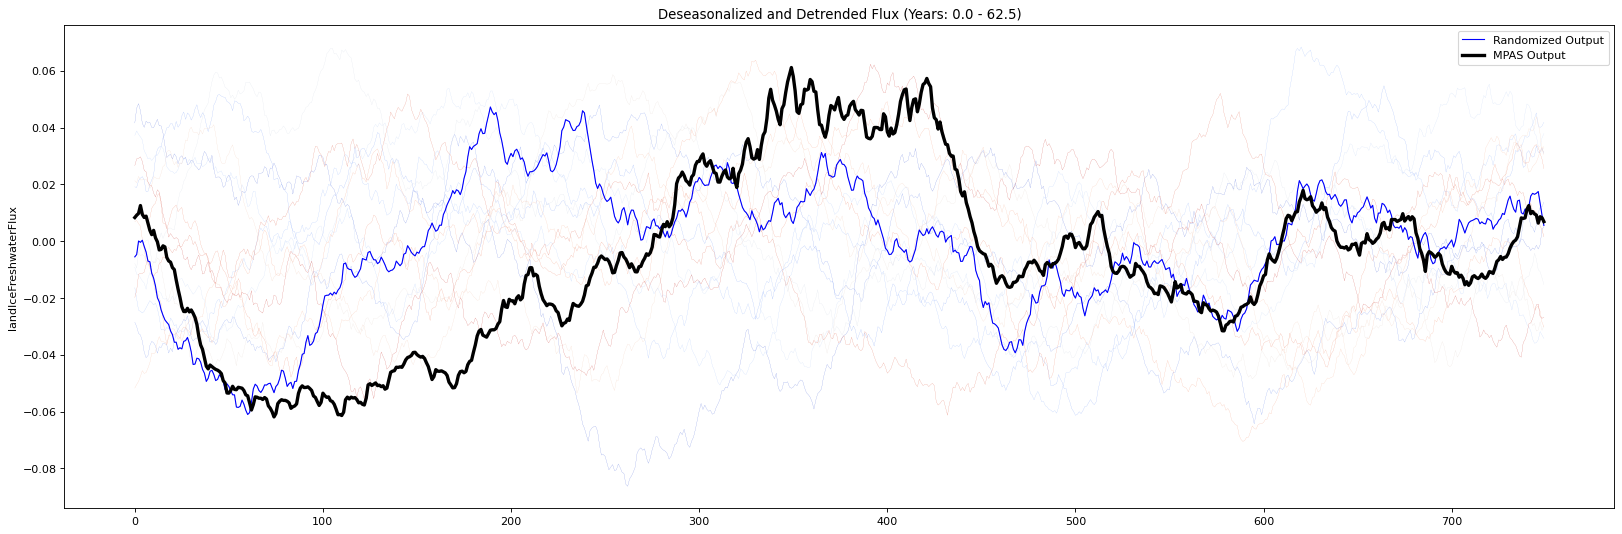

In [174]:
# ======================================================
# PHASE RANDOMIZED TIME SERIES PLOTS (PCs) =============
# ======================================================

plt.figure(figsize=(25, 8), dpi=80)

n_mode = 0

for i in range(n_realizations):
    plt.plot(new_fl[i,t1:tf,n_mode],c=cmap(i/n_realizations), linewidth=0.15)

plt.plot(new_fl[0,t1:tf,n_mode],'b', linewidth=1, label='Randomized Output')
plt.plot(xeofs_pcs[t1:tf,n_mode],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f})'.format((t1)/12,(tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [173]:
from matplotlib import rcParams, cycler
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, 10)))

In [169]:
from matplotlib import colors
cmap = colors.LinearSegmentedColormap('blues', cdict)

In [ ]:
# xeofs_pcs_rand = xr.DataArray(new_fl[0], coords=xeofs_pcs.coords, dims = xeofs_pcs.dims, attrs=xeofs_pcs.attrs)

In [ ]:
%%time
# Reconstruct flux dataset using phase randomized PCs.
# This section is to be called iteratively for ensemble runs with multiple realizations.
# This method also takes 'modes' as a parameter - used to reconstruct dataset with different number of selected modes
xeofs_rec_rand = model.reconstruct_randomized_X(new_fl[0],slice(1,1,1))

In [ ]:
for xeofs_modes in range(1,xeofs_n_modes+1):
    xeofs_rec_rand = model.reconstruct_randomized_X(new_fl[0],slice(1,xeofs_modes,1))

In [73]:
def clip_data(total_data, basin):
    #with rioxarray.set_options(export_grid_mapping=False):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'],from_disk=True).squeeze()
    clipped_data = clipped_data.dropna('time',how='all')
    clipped_data = clipped_data.dropna('y',how='all')
    clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [10]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [11]:
def psd_calc(time_series):
    psd_arr = plt.psd(time_series)
    return psd_arr

In [141]:
#basins = [34,55,104,114]
basins = [114]
xeofs_modes = list(range(1,xeofs_n_modes+1))

In [142]:
def generate_data(mode):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[0],slice(1,mode,10))
    return flux_reconstr

In [92]:
def basinplot_func(basin, mode):
    print("Generating reconstructed data, mode = {}".format(mode))
    flux_reconstr = generate_data(mode)
    print("Clipping original data")
    #orig_basin = clip_data(flux_clean, basin)
    print("Clipping reconstructed data")
    rec_basin = clip_data(flux_reconstr, basin)
    orig_basin_ts = time_series(orig_basin)
    rec_basin_ts = time_series(rec_basin)
    orig = psd_calc(orig_basin_ts);
    rec = psd_calc(rec_basin_ts);
    rmse = sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))
    del flux_reconstr, orig_basin, rec_basin, orig_basin_ts, rec_basin_ts, orig, rec
    gc.collect()
    return rmse

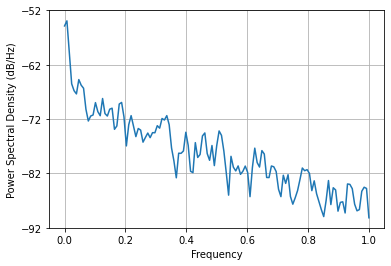

In [143]:
orig_basin = clip_data(flux_clean, 114)
orig_basin_ts = time_series(orig_basin)
orig = psd_calc(orig_basin_ts);

def basinplot_func_clean(basin, mode):
    print("Generating reconstructed data, mode = {}".format(mode))
    flux_reconstr = generate_data(mode)
    print("Clipping reconstructed data")
    rec_basin = clip_data(flux_reconstr, basin)
    rec_basin_ts = time_series(rec_basin)
    rec = psd_calc(rec_basin_ts);
    rmse = sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))
    del flux_reconstr, rec_basin, rec_basin_ts, rec
    gc.collect()
    return rmse

In [58]:
def basin_rmse(flux_reconstr, basin):
    orig_basin = clip_data(flux_clean, basin)
    rec_basin = clip_data(flux_reconstr, basin)
    orig_basin_ts = time_series(orig_basin)
    rec_basin_ts = time_series(rec_basin)
    orig = psd_calc(orig_basin_ts);
    rec = psd_calc(rec_basin_ts);
    rmse = sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))
    del flux_reconstr, orig_basin, rec_basin, orig_basin_ts, rec_basin_ts, orig, rec
    gc.collect()
    return rmse

CPU times: user 44.3 s, sys: 1min 20s, total: 2min 5s
Wall time: 2min 14s


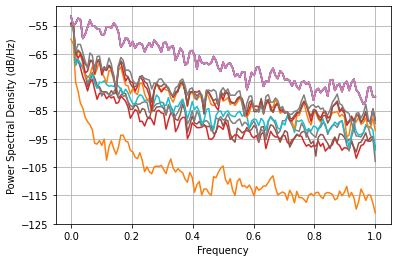

In [62]:
%%time
rmse_results = []
for mode in range(1,10):
    flux_reconstr = generate_data(mode)
    rmse = basin_rmse(flux_reconstr, 104)
    rmse_results.append(rmse)

In [144]:
%%time
rmse_results = list(map(basinplot_func_clean, *zip(*product(basins,xeofs_modes))))

Generating reconstructed data, mode = 1
Clipping reconstructed data
Generating reconstructed data, mode = 2
Clipping reconstructed data
Generating reconstructed data, mode = 3
Clipping reconstructed data
Generating reconstructed data, mode = 4
Clipping reconstructed data
Generating reconstructed data, mode = 5
Clipping reconstructed data
Generating reconstructed data, mode = 6
Clipping reconstructed data
Generating reconstructed data, mode = 7
Clipping reconstructed data
Generating reconstructed data, mode = 8
Clipping reconstructed data
Generating reconstructed data, mode = 9
Clipping reconstructed data
Generating reconstructed data, mode = 10
Clipping reconstructed data
Generating reconstructed data, mode = 11
Clipping reconstructed data
Generating reconstructed data, mode = 12
Clipping reconstructed data
Generating reconstructed data, mode = 13
Clipping reconstructed data
Generating reconstructed data, mode = 14
Clipping reconstructed data
Generating reconstructed data, mode = 15
Cl

Clipping reconstructed data
Generating reconstructed data, mode = 120
Clipping reconstructed data
Generating reconstructed data, mode = 121
Clipping reconstructed data
Generating reconstructed data, mode = 122
Clipping reconstructed data
Generating reconstructed data, mode = 123
Clipping reconstructed data
Generating reconstructed data, mode = 124
Clipping reconstructed data
Generating reconstructed data, mode = 125
Clipping reconstructed data
Generating reconstructed data, mode = 126
Clipping reconstructed data
Generating reconstructed data, mode = 127
Clipping reconstructed data
Generating reconstructed data, mode = 128
Clipping reconstructed data
Generating reconstructed data, mode = 129
Clipping reconstructed data
Generating reconstructed data, mode = 130
Clipping reconstructed data
Generating reconstructed data, mode = 131
Clipping reconstructed data
Generating reconstructed data, mode = 132
Clipping reconstructed data
Generating reconstructed data, mode = 133
Clipping reconstruct

Generating reconstructed data, mode = 237
Clipping reconstructed data
Generating reconstructed data, mode = 238
Clipping reconstructed data
Generating reconstructed data, mode = 239
Clipping reconstructed data
Generating reconstructed data, mode = 240
Clipping reconstructed data
Generating reconstructed data, mode = 241
Clipping reconstructed data
Generating reconstructed data, mode = 242
Clipping reconstructed data
Generating reconstructed data, mode = 243
Clipping reconstructed data
Generating reconstructed data, mode = 244
Clipping reconstructed data
Generating reconstructed data, mode = 245
Clipping reconstructed data
Generating reconstructed data, mode = 246
Clipping reconstructed data
Generating reconstructed data, mode = 247
Clipping reconstructed data
Generating reconstructed data, mode = 248
Clipping reconstructed data
Generating reconstructed data, mode = 249
Clipping reconstructed data
Generating reconstructed data, mode = 250
Clipping reconstructed data
Generating reconstru

Clipping reconstructed data
Generating reconstructed data, mode = 355
Clipping reconstructed data
Generating reconstructed data, mode = 356
Clipping reconstructed data
Generating reconstructed data, mode = 357
Clipping reconstructed data
Generating reconstructed data, mode = 358
Clipping reconstructed data
Generating reconstructed data, mode = 359
Clipping reconstructed data
Generating reconstructed data, mode = 360
Clipping reconstructed data
Generating reconstructed data, mode = 361
Clipping reconstructed data
Generating reconstructed data, mode = 362
Clipping reconstructed data
Generating reconstructed data, mode = 363
Clipping reconstructed data
Generating reconstructed data, mode = 364
Clipping reconstructed data
Generating reconstructed data, mode = 365
Clipping reconstructed data
Generating reconstructed data, mode = 366
Clipping reconstructed data
Generating reconstructed data, mode = 367
Clipping reconstructed data
Generating reconstructed data, mode = 368
Clipping reconstruct

Generating reconstructed data, mode = 472
Clipping reconstructed data
Generating reconstructed data, mode = 473
Clipping reconstructed data
Generating reconstructed data, mode = 474
Clipping reconstructed data
Generating reconstructed data, mode = 475
Clipping reconstructed data
Generating reconstructed data, mode = 476
Clipping reconstructed data
Generating reconstructed data, mode = 477
Clipping reconstructed data
Generating reconstructed data, mode = 478
Clipping reconstructed data
Generating reconstructed data, mode = 479
Clipping reconstructed data
Generating reconstructed data, mode = 480
Clipping reconstructed data
Generating reconstructed data, mode = 481
Clipping reconstructed data
Generating reconstructed data, mode = 482
Clipping reconstructed data
Generating reconstructed data, mode = 483
Clipping reconstructed data
Generating reconstructed data, mode = 484
Clipping reconstructed data
Generating reconstructed data, mode = 485
Clipping reconstructed data
Generating reconstru

Clipping reconstructed data
Generating reconstructed data, mode = 590
Clipping reconstructed data
Generating reconstructed data, mode = 591
Clipping reconstructed data
Generating reconstructed data, mode = 592
Clipping reconstructed data
Generating reconstructed data, mode = 593
Clipping reconstructed data
Generating reconstructed data, mode = 594
Clipping reconstructed data
Generating reconstructed data, mode = 595
Clipping reconstructed data
Generating reconstructed data, mode = 596
Clipping reconstructed data
Generating reconstructed data, mode = 597
Clipping reconstructed data



KeyboardInterrupt



Error in callback <function flush_figures at 0x17ee48790> (for post_execute):


KeyboardInterrupt: 

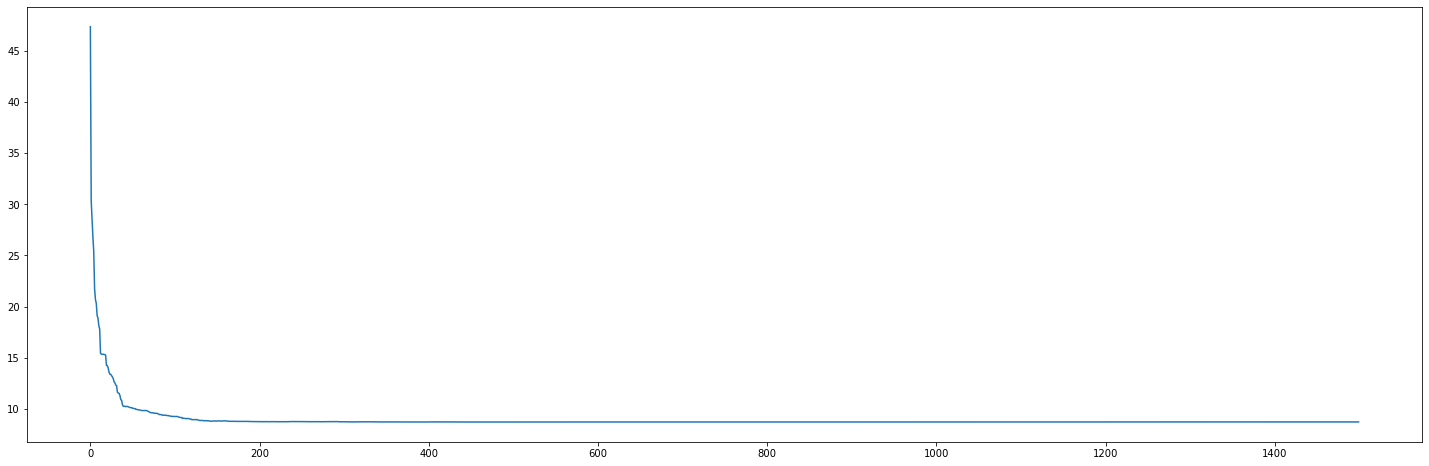

In [137]:
plt.figure(figsize=(25, 8))
plt.plot(rmse_104)

In [136]:
min(rmse_results)

8.69845444606481

In [135]:
rmse_114 = np.asarray(rmse_results)

In [138]:
np.argmin(rmse_104)

381

In [140]:
np.save("rmse_104.npy", rmse_104)

In [ ]:
%%time
fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()
i=0


for modes in range(1,1501):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[0],slice(1,modes,1))
    for basin in basins:
        orig_basin = clip_data(flux_clean, basin)
        rec_basin = clip_data(flux_reconstr, basin)
        orig_basin_ts = time_series(orig_basin)
        rec_basin_ts = time_series(rec_basin)
        orig = psd_calc(orig_basin_ts);
        rec = psd_calc(rec_basin_ts);
        axs[i].plot(rec[1], 10*np.log10(rec[0]), color = 'b')
        axs[i].plot(orig[1], 10*np.log10(orig[0]), label='Original', linewidth=3, color='k')
        rmse = sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))
        axs[i].set_title('PSD Comparison: {0}'.format(icems.name.values[basin]))
        del orig_basin, rec_basin, orig_basin_ts, rec_basin_ts, orig, rec, rmse
        print('deleting interim variables')
        gc.collect()
        i=i+1